In [1]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
import os, sys, h5py
main_dir = os.path.abspath('../../')
if main_dir not in sys.path: sys.path.append(main_dir)

from modes.functions import *
from modes.affinemodel import AffineTransformModel


device = 'cuda:3'


truncate_circle = False

Load the Modes and the derivatives

In [2]:
microlens = 20 #20x20
size = microlens

n_zernike_rows = 3
n_zernike = n_zernike_rows*(n_zernike_rows+1)//2

x = torch.linspace(-1,1,size)
y = torch.linspace(-1,1,size)

xx, yy = torch.meshgrid(x,y)

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Make a custom wavefront...

Text(0.5, 1.0, 'True Wavefront Derivative')

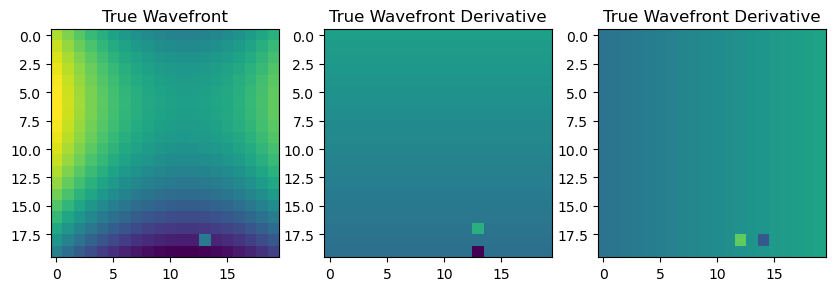

In [13]:
wavefront = torch.zeros(size,size)

decenter = [0.2,0.2]

modes, mode_derivs = get_modes_and_derivs(decenter, xx, yy, n_zernike=n_zernike_rows, truncate_circle=False, pixel_basis = True)

mode_coeffs = torch.zeros((len(modes),1,1))


elements = np.arange(n_zernike)
np.random.shuffle(elements)
elements = elements[:3]
zer_coeffs = torch.randn(len(elements),1,1)

mode_coeffs[elements] = zer_coeffs
# mode_coeffs[n_zernike] = 1 #vortex

mode_coeffs[380] = 1

wavefront = torch.sum(mode_coeffs * modes,dim=0)
wavefront_deriv = torch.sum(mode_coeffs * mode_derivs,dim=1)


fig,ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(wavefront); ax[0].set_title('True Wavefront')
ax[1].imshow(wavefront_deriv[0],vmax=1,vmin=-1); ax[1].set_title('True Wavefront Derivative')
ax[2].imshow(wavefront_deriv[1],vmax=1,vmin=-1); ax[2].set_title('True Wavefront Derivative')

## From here I show once we have gradients


In [14]:
sampled_gradient = wavefront_deriv.clone()
sampled_gradient[:,10,10] = np.nan

sampled_gradient+=torch.randn_like(sampled_gradient)*0.01 * torch.max(torch.nan_to_num(sampled_gradient))

evaller = ModalEvaluator(size=(size,size), n_zernike_rows=n_zernike_rows, zern_transform=False, device=device)

In [15]:
coeffs, history = evaller.fit(sampled_gradient, epochs=8000, lr=1e-3, l1_reg=5e-4)

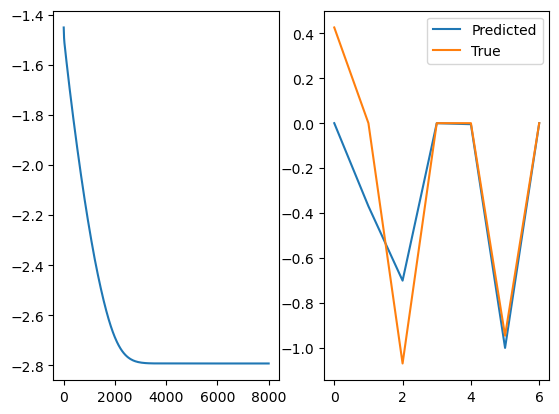

In [16]:
fig,ax = plt.subplots(1,2)
ax[0].plot(np.log10(history['loss']))
ax[1].plot(coeffs[0].detach().cpu()/2)
ax[1].plot(mode_coeffs[:7,0,0])
ax[1].legend(['Predicted','True'])

In [17]:
coeffs[-1]

tensor([-5.7127e-05, -7.4023e-01, -1.4031e+00, -3.6181e-04, -9.3153e-03,
        -2.0026e+00,  4.4426e-05], device='cuda:3')

In [18]:
evaller.dictionary.shape, evaller.dictionary_grads.shape

(torch.Size([7, 1, 40, 40]), torch.Size([7, 2, 40, 40]))

In [19]:
wavefront_pred, derivs_pred =  evaller.get_wavefront(coeffs, microlens_pitch=1)

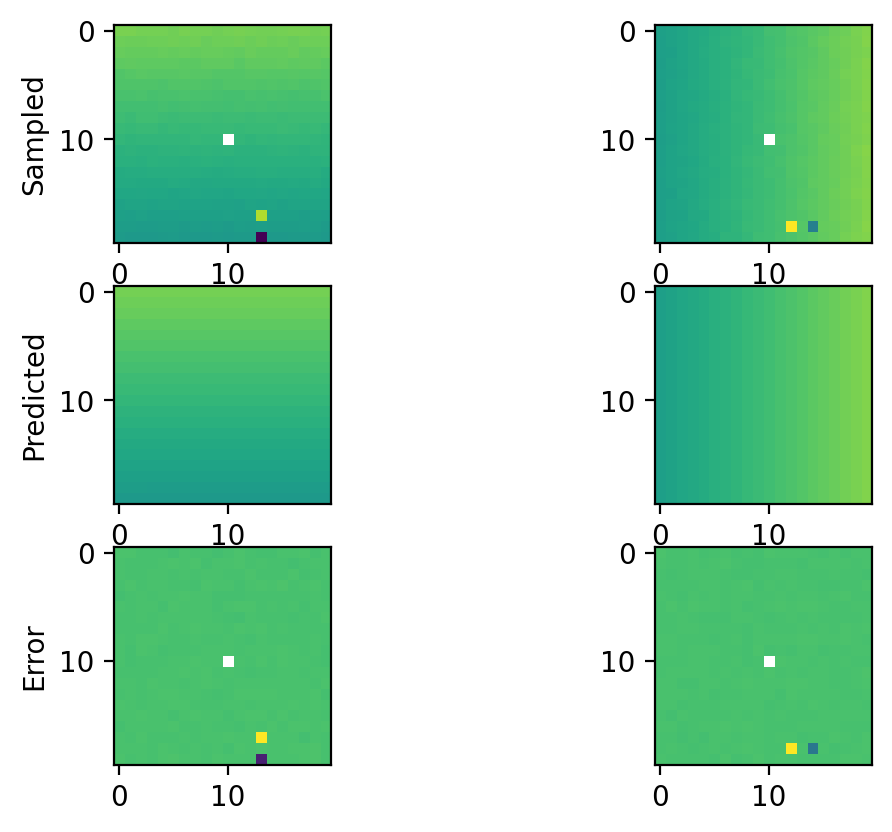

In [20]:
vmax = torch.nan_to_num(sampled_gradient).max()*.9
vmin = torch.nan_to_num(sampled_gradient).min()*.9

fig,ax = plt.subplots(3,2,dpi=200)
ax[0,0].imshow(sampled_gradient[0],vmax=vmax, vmin=vmin); ax[0,0].set_ylabel('Sampled')
ax[0,1].imshow(sampled_gradient[1],vmax=vmax, vmin=vmin)
ax[1,0].imshow(derivs_pred[0],vmax=vmax, vmin=vmin); ax[1,0].set_ylabel('Predicted')
ax[1,1].imshow(derivs_pred[1],vmax=vmax, vmin=vmin)
ax[2,0].imshow(sampled_gradient[0]-derivs_pred[0],vmax=vmax, vmin=vmin); ax[2,0].set_ylabel('Error')
ax[2,1].imshow(sampled_gradient[1]-derivs_pred[1],vmax=vmax, vmin=vmin)

Text(0.5, 1.0, 'Error')

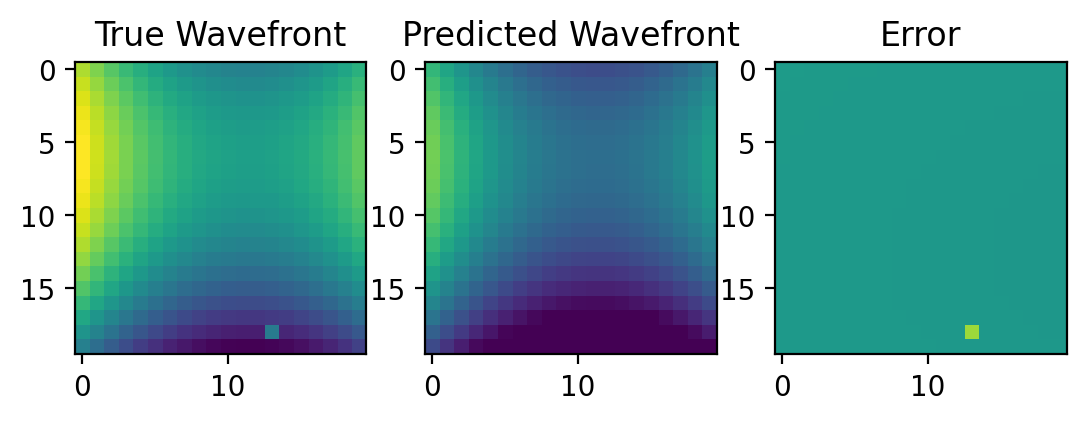

In [21]:
vmax = wavefront.max()
vmin = wavefront.min()

fig,ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(wavefront,vmax=vmax,vmin=vmin); ax[0].set_title('True Wavefront')
ax[1].imshow(wavefront_pred,vmax=vmax,vmin=vmin); ax[1].set_title('Predicted Wavefront')
ax[2].imshow(wavefront-wavefront_pred,vmax=vmax,vmin=vmin); ax[2].set_title('Error')

#(wavefront_pred/wavefront).mean(), (wavefront_pred/wavefront).std()

In [22]:
evaller.aff_model.rot_list, evaller.aff_model.transX_list, evaller.aff_model.transY_list

(Parameter containing:
 tensor([ 0.0000, -0.3013], device='cuda:3', requires_grad=True),
 Parameter containing:
 tensor([0.0000, 0.0018], device='cuda:3', requires_grad=True),
 Parameter containing:
 tensor([0.0000, 0.0319], device='cuda:3', requires_grad=True))

In [123]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [48]:
n_zernike_rows=28

n_zernike_rows * (n_zernike_rows+1) // 2    

406

In [138]:
size = 21
decenter = [0,0]

n_zernike_rows=28

x = torch.linspace(-1,1,size)
y = torch.linspace(-1,1,size)

xx, yy = torch.meshgrid(x,y)


modes, mode_derivs = get_modes_and_derivs(decenter, xx, yy, n_zernike=n_zernike_rows, truncate_circle=False, pixel_basis = False)

vortex = modes[-1:]
zernikes = modes[:-1]

single_peak = torch.zeros_like(xx)[None]
single_peak[:,size//4,size//4] = 1


r = torch.sqrt(xx**2 + yy**2)
mask = (r>1)

vortex[:,mask] = 0
zernikes[:,mask] = 0

single_peak_coeffs = (single_peak * zernikes).sum((1,2))
coeffs = (vortex * zernikes).sum((1,2))

zernikes[:,mask] = np.nan
vortex[:,mask] = np.nan

row2coeffs = (coeffs[:3,None,None] * zernikes[:3]).sum(0)
row3coeffs = (coeffs[:6,None,None] * zernikes[:6]).sum(0)
row4coeffs = (coeffs[:15,None,None] * zernikes[:15]).sum(0)
row6coeffs = (coeffs[:21,None,None] * zernikes[:21]).sum(0)

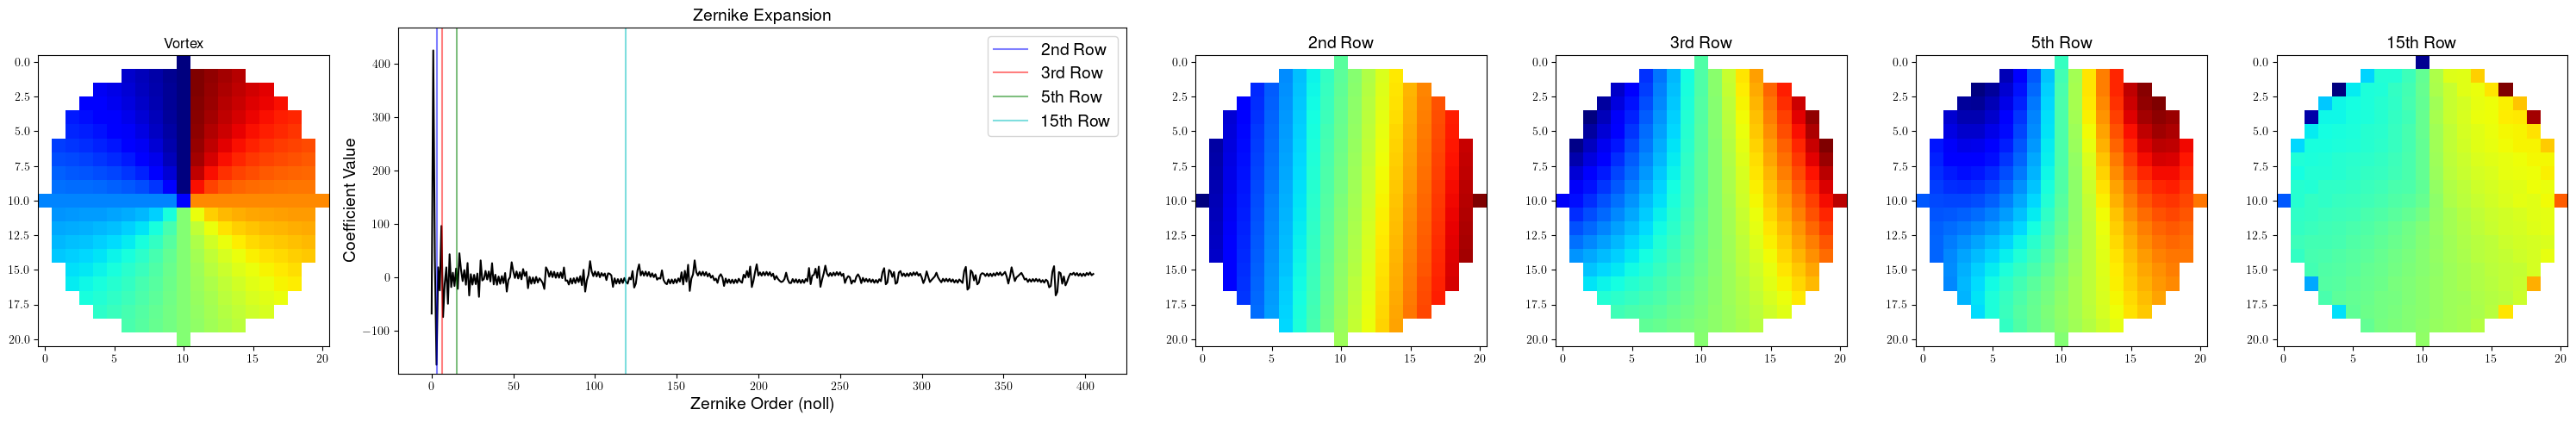

In [139]:
fig,ax = plt.subplots(1,6, figsize=(30,5), width_ratios=[1,2.5,1,1,1,1], )
ax[0].imshow(vortex[0],cmap='jet'); ax[0].set_title('Vortex')

ax[1].plot(coeffs, 'k'); ax[1].set_xlabel('Zernike Order (noll)', fontsize=14); ax[1].set_ylabel('Coefficient Value', fontsize=14); ax[1].set_title('Zernike Expansion', fontsize=14)

ax[1].plot(np.ones(10)*3.5, np.linspace(-1000000,1000000,10), 'b', alpha=.5, label='2nd Row')
ax[1].plot(np.ones(10)*6.5, np.linspace(-1000000,1000000,10), 'r', alpha=.5, label='3rd Row')
ax[1].plot(np.ones(10)*15.5, np.linspace(-1000000,1000000,10), 'g', alpha=.5, label='5th Row')
ax[1].plot(np.ones(10)*119, np.linspace(-1000000,1000000,10), 'c', alpha=.5, label='15th Row')
ax[1].legend(fontsize=14)

ax[1].set_ylim((coeffs.min()*1.1,coeffs.max()*1.1))

ax[2].imshow(row2coeffs,cmap='jet'); ax[2].set_title('2nd Row', fontsize=14)
ax[3].imshow(row3coeffs,cmap='jet'); ax[3].set_title('3rd Row', fontsize=14)
ax[4].imshow(row4coeffs,cmap='jet'); ax[4].set_title('5th Row', fontsize=14) 
# ax[5].imshow(row6coeffs,cmap='jet'); ax[5].set_title('6th Row', fontsize=14)
ax[5].imshow((coeffs[:,None,None] * zernikes[:]).sum(0),cmap='jet'); ax[5].set_title('15th Row', fontsize=14)
plt.tight_layout()

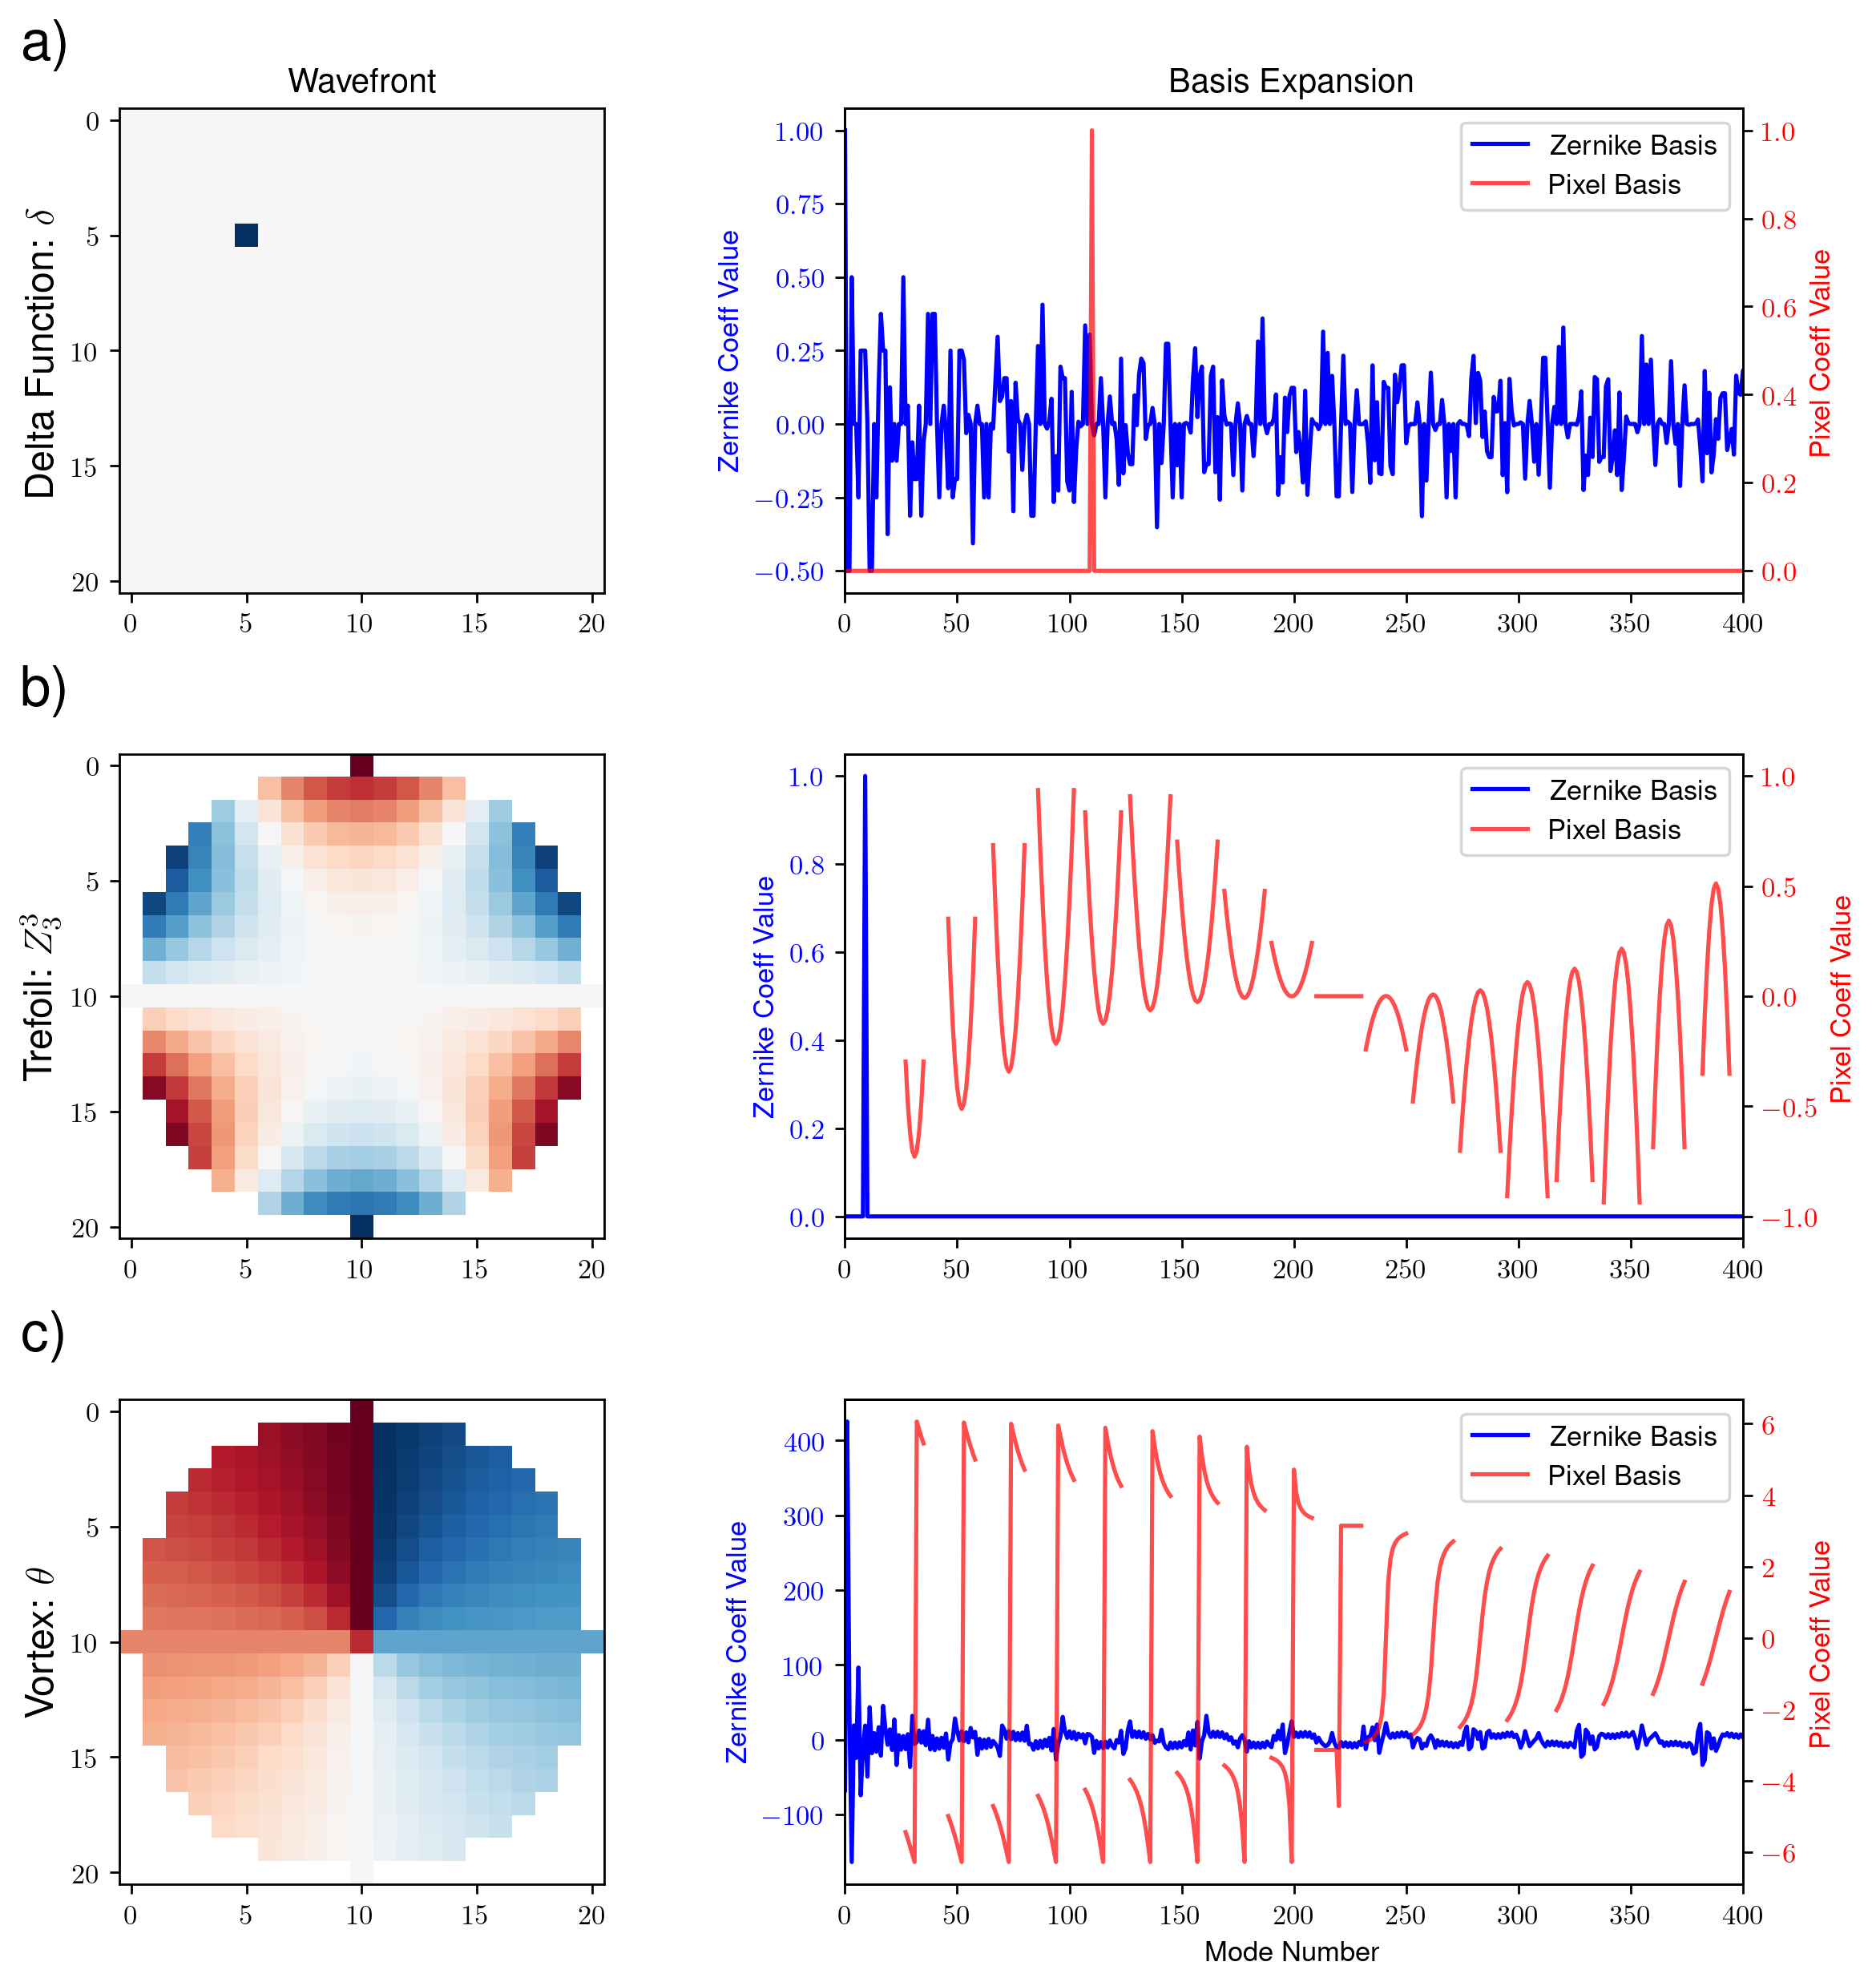

In [157]:
fig,ax = plt.subplots(3,2, figsize=(10,10), dpi=250)
ax[0,0].imshow(single_peak[0],cmap='RdBu', vmax=1, vmin=-1); ax[0,0].set_title('Wavefront'); ax[0,0].set_ylabel(r'Delta Function: $\delta$', fontsize=14)
ax[0,0].text(-0.2, 1.1, 'a)', transform=ax[0,0].transAxes, 
            size=20, weight='bold')
lns1= ax[0,1].plot(single_peak_coeffs, 'b',label='Zernike Basis'); ax[0,1].set_title('Basis Expansion')
ax[0,1].set_ylabel('Zernike Coeff Value', color='b')
ax[0,1].tick_params(axis='y', labelcolor='blue')
ax2 = ax[0,1].twinx() 
lns2 = ax2.plot(single_peak[0].flatten(), 'r', alpha=.7, label='Pixel Basis')

ax2.set_ylabel('Pixel Coeff Value', color='r')
ax2.tick_params(axis='y', labelcolor='r')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0,1].legend(lns, labs, loc=0)
ax[0,1].set_xlim(0,400)

ax[1,0].imshow(zernikes[9],cmap='RdBu', vmax=1, vmin=-1);ax[1,0].set_ylabel(r'Trefoil: $Z_{3}^{3}$', fontsize=14)
ax[1,0].text(-0.2, 1.1, 'b)', transform=ax[1,0].transAxes, 
            size=20, weight='bold')

zernicoeff = np.zeros_like(coeffs)
zernicoeff[9] = 1
lns1= ax[1,1].plot(zernicoeff, 'b',label='Zernike Basis')
ax[1,1].set_ylabel('Zernike Coeff Value', color='b')
ax[1,1].tick_params(axis='y', labelcolor='blue')
ax2 = ax[1,1].twinx() 
lns2 = ax2.plot(zernikes[9].flatten(), 'r', alpha=.7, label='Pixel Basis')

ax2.set_ylabel('Pixel Coeff Value', color='r')
ax2.tick_params(axis='y', labelcolor='r')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[1,1].legend(lns, labs, loc=0)
ax[1,1].set_xlim(0,400)


ax[2,0].imshow(vortex[0],cmap='RdBu');ax[2,0].set_ylabel(r'Vortex: $\theta$', fontsize=14)
ax[2,0].text(-0.2, 1.1, 'c)', transform=ax[2,0].transAxes, 
            size=20, weight='bold')

lns1= ax[2,1].plot(coeffs, 'b',label='Zernike Basis')
ax[2,1].set_ylabel('Zernike Coeff Value', color='b')
ax[2,1].tick_params(axis='y', labelcolor='blue')
ax2 = ax[2,1].twinx() 
lns2 = ax2.plot(vortex.flatten(), 'r', alpha=.7, label='Pixel Basis')

ax2.set_ylabel('Pixel Coeff Value', color='r')
ax2.tick_params(axis='y', labelcolor='r')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[2,1].legend(lns, labs, loc=0)

ax[2,1].set_xlim(0,400)
ax[2,1].set_xlabel('Mode Number')

plt.tight_layout()



